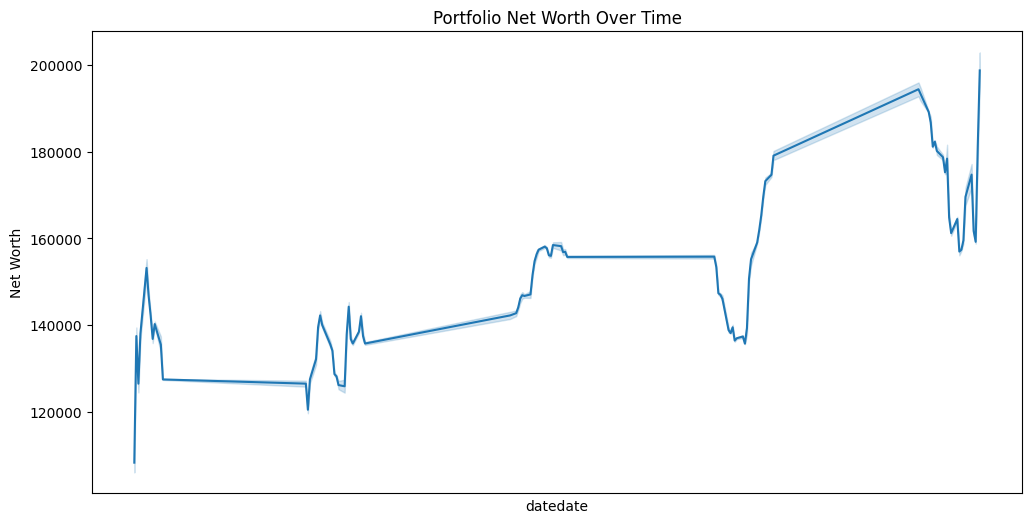

In [14]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Declaring the Hyperparameters
N = 50
T = 7
R = 0.8
M = 5
F = 0.0005   # 0.5% Brokerage fee

# Step 1: Define a function to read the Prices of various Stocks into memory
def GetData(NameOfFile):
    df = pd.read_csv(NameOfFile, usecols=["datadate", "tic", "adjcp"])
    return df

# Step 2: Partition the Data based on Dates
def PartitionData(Data):
    DateToIndex = {}
    partitioned_data = []
    grouped = Data.groupby("datadate")
    for date, group in grouped:
        partitioned_data.append(group)
        DateToIndex[date] = len(partitioned_data) - 1
    return partitioned_data, DateToIndex

# Step 3: Calculate Momentum-based Priority
def GetMomentumBasedPriority(PartitionedDataFrameList, DateToIndex ,today):
    today_index = DateToIndex[today]
    NdaysAgo_index = today_index - N
    if NdaysAgo_index < 0:
        NdaysAgo_index = 0
    NdaysAgo = PartitionedDataFrameList[NdaysAgo_index]["datadate"].values[-1]
    selected_data = PartitionedDataFrameList[today_index]
    NdaysAgo_data = PartitionedDataFrameList[NdaysAgo_index]

    momentum = selected_data["adjcp"].values - NdaysAgo_data["adjcp"].values
    mean = np.mean(NdaysAgo_data["adjcp"].values)
    momentum_by_mean = momentum / mean
    
    return momentum_by_mean

# Step 4: Calculate how many stocks to buy for each ticker
def GetBalanced(prices, weights, balance):
    total_value = np.sum(prices * weights)
    shares_to_buy = (balance * weights) / prices
    return shares_to_buy

# Step 5: Create Portfolio class to simulate portfolio actions
class Portfolio:
    def __init__(self, balance, prices):
        self.balance = balance
        self.shares = np.zeros(len(prices))
        self.prices = prices

    def SellStock(self, index):
        self.balance += self.prices[index] * self.shares[index] * (1 - F)
        self.shares[index] = 0

    def BuyStock(self, index, number):
        cost = self.prices[index] * number
        if cost > self.balance:
            number = self.balance // self.prices[index]
        self.balance -= self.prices[index] * number * (1 + F)
        self.shares[index] += number

    def CalculateNetWorth(self):
        return self.balance + np.sum(self.prices * self.shares)

    def ChangePricesTo(self, newPriceVector):
        self.prices = newPriceVector

    def RebalancePortfolio(self, newWeights):
        for i in range(len(self.shares)):
            self.SellStock(i)

        sorted_indices = np.argsort(newWeights)[-M:]
        weights = np.zeros(len(newWeights))
        weights[sorted_indices] = newWeights[sorted_indices]
        shares_to_buy = GetBalanced(self.prices, weights, self.balance)

        for i in range(len(shares_to_buy)):
            self.BuyStock(i, shares_to_buy[i])

# Step 6: Visualize Data
def VisualizeData(df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x="datadate", y="Net Worth")
    plt.xlabel("datedate")
    plt.ylabel("Net Worth")
    plt.title("Portfolio Net Worth Over Time")
    plt.show()

# Main Loop
myPortfolio = Portfolio(100000, np.zeros(30))
NetWorthAfterEachTrade = []

# Step 1: Get the Data
Data = GetData(r"C:\Users\soura\Downloads\DATA.csv")


# Step 2: Partition the Data
PartitionedData, DateToIndex = PartitionData(Data)

# Step 3: Loop through the data from (N+1)th day onwards
for i in range(N, len(PartitionedData)):
    today = PartitionedData[i]["datadate"].values[-1]
    
    # Step 4: Change the Prices to the latest prices
    prices = PartitionedData[i]["adjcp"].values
    myPortfolio.ChangePricesTo(prices)

    # Step 5: Calculate Net Worth and store in list
    NetWorthAfterEachTrade.append(myPortfolio.CalculateNetWorth())

    # Step 6: Check if it's time to rebalance the portfolio
    if (i - N) % T == 0:
        momentum_by_mean = GetMomentumBasedPriority(PartitionedData, DateToIndex, today)
        myPortfolio.RebalancePortfolio(momentum_by_mean)

# Visualize the Portfolio Performance
# Concatenate DataFrames in PartitionedData list
concatenated_df = pd.concat(PartitionedData[N:], ignore_index=True)

# Convert "datadate" to datetime
concatenated_df["datadate"] = pd.to_datetime(concatenated_df["datadate"])

# Ensure lengths match and create the final DataFrame
min_len = min(len(concatenated_df["datadate"]), len(NetWorthAfterEachTrade))
df = pd.DataFrame({"datadate": concatenated_df["datadate"].iloc[:min_len],
                   "Net Worth": NetWorthAfterEachTrade[:min_len]})



VisualizeData(df)